# Series Expansions

Series expansions are used in a variety of circumstances:
- When we need a tractable approximation to some ugly equation
- To transform between equivalent ways of looking at a problem (e.g. time domain vs frequency domain)
- When they are (part of) a solution to a particular class of differential equation

For approximations, there is an important divide between getting the best fit *near a point* (e.g. [Taylor series](#taylor)) and getting the best fit *over an interval* (e.g. [Fourier series](#fourier)).

## Contents
- [Fitting near a point](#point)
    - [Taylor/Maclaurin](#taylor)
- [Fitting over an interval](#interval)
    - [Fourier series](#fourier)
    - [Bessel functions](#bessel)
    - [Legendre polynomials](#legendre)
- [References](#refs)

<a id='point'></a>

## Fitting near a point

What is the best (low order) polymomial approximating my function at *this* point? It doesn't matter if it diverges wildly as we get far away from the point, though adding higher-order terms may extend the range of usefulness.



<a id='taylor'></a>

## Taylor and Maclaurin series

A function $f(x)$ can be approximated at a point $x=a$ by the polynomial

$$ f(x) \approx f(a) + f'(a) (x-a) + \frac{1}{2} f''(a) (x-a)^2 \dots \frac{1}{n!} f^n(a) (x-a)^n $$

For this to converge, either $(x-a)$ should be small so we can ignore high powers, or the differentials should become zero.

The general case for $x=a$ is the Taylor Series. The special case where $x=0$ is sometimes called the Maclaurin series.

For the Python sections we will need a substantial range of imports, adding SymPy to the usual set of numpy, matplotlib and widgets.

In [8]:
from sympy import * # TODO - narrow this later
init_printing()
from sympy.functions import sin, cos

from sympy.parsing.sympy_parser import parse_expr
from sympy.parsing.sympy_parser import standard_transformations, implicit_multiplication_application
transformations = (standard_transformations + (implicit_multiplication_application,))

import numpy as np
import matplotlib.pyplot as plt
from math import factorial

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as w

plt.rcParams.update({'font.size': 16})

Define some functions to be used later, plus a SymPy symbol.

In [11]:
# Define the variable for SymPy functions
x = Symbol('x')

# Taylor approximation at x=a of function f, to order n
def taylor(f, a, n):
    # f is a SymPy function
    terms = []
    for i in range(n+1):
        terms.append((f.diff(x, i).subs(x, a))/(factorial(i))*(x - a)**i)
    return terms

# Plot results
def plotTaylor(f_sympy, a, n):
    
    # get a NumPy-style function from the SymPy version
    f_np = lambdify(x, f_sympy, 'numpy')
    
    # plot the starting function
    x_lims = [-5,5]
    x1 = np.linspace(x_lims[0], x_lims[1], 500)
    plt.figure(figsize=(9, 9))
    plt.plot(x1, f_np(x1), 'k.', label=f_sympy)
    
    # get n terms of a Taylor series 
    f_taylor_terms = taylor(f_sympy, 0, n) # a list
    f_taylor = sum(f_taylor_terms) # the whole func to order n
    display(f_sympy) # display shows LaTex, print wouldn't
    print('Taylor expansion at x = {:.2f}, n = {:d}:'.format(a, n))
    display(f_taylor)

    # plot the successive approximations
    y = np.zeros(len(x1))
    for i in range(n):
        term = f_taylor_terms[i]
        if term.is_zero: 
            # odd or even functions only use alternate terms
            continue
        term_np = lambdify(x, term, 'numpy')
        y += term_np(x1)
        plt.plot(x1, y, label='order ' + str(i+1))

    # graph housekeeping
    plt.xlim(x_lims)
    plt.ylim([-3,3])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.title('Taylor series approximation of ' + str(f_sympy))

We will want to enter arbitrary functions into a text box, but these need to be parsed into a form that SymPy (and plotTaylor()) can use.

Note the variety of formats for our function: we start with a text string, parse it to a SymPy object suitable for symbolic math (differentiation, etc), 'lambdify' it to a NumPy function which can handle array input, and finally generate a plottable array of y-values.

In [12]:
def parse_input(f_txt, a, n):
    f_sympy = parse_expr(f_txt, transformations=transformations)
    plotTaylor(f_sympy, a, n)

Enter any valid Python function into the text box. Enter or Tab will get trigger a redraw. Don't forget to use `**` for exponentiation rather than `^`!

Implicit multiplication may work, e.g. `x sin(x)` as a synonym for `x*sin(x)`. Adding a space improves your chances of success.

The parser presumably has limits but it's unclear what they are. Experiment...

In [13]:
style = {'description_width': 'initial'} # to avoid the labels getting truncated
interact(parse_input, 
             f_txt = w.Text(description='f(x):',
                                            layout=Layout(width='80%'),
                                            continuous_update=False,
                                            value='sin(x)'),
             a = w.FloatSlider(description="Evaluation point $a$", style=style,
                                            layout=Layout(width='80%'),
                                            continuous_update=False,
                                            min=-4, max=4, 
                                            value=0),
             n = w.IntSlider(description="Number of terms $n$", style=style,
                                            layout=Layout(width='80%'),
                                            continuous_update=False, 
                                            min=1, max=20,
                                            value=6));

interactive(children=(Text(value='sin(x)', continuous_update=False, description='f(x):', layout=Layout(width='…

<a id='interval'></a>

## Fitting over an interval

What is the best (tractable) series approximating my function across some range of values? Now what matters is an overall best fit (e.g. least-squares deviation) across the range, and we can't tolerate wild divergences as with the Taylor series.

There are various series which are useful in different contexts, but a common property is that the terms are *orthogonal* over some interval $[-L,L]$. If $f(t)$ is a real-valued function their *inner product* is defined as

$$ \langle f(m t),f(n t) \rangle   \colon =\int _{-L}^L f(m t) f(n t) \,  dt $$

For orthogonal functions, this is non-zero if $m=n$ and zero if $m \ne n$.

<a id='fourier'></a>

## Fourier Series and Fourier Analysis

A periodic function $f$ of period $2L$ can be approximated by a Fourier Series of sines and cosines:

$$ f(t) = \frac{a_0}{2} + \sum _{n \ge 1} a_ n \cos \frac{n \pi t}{L} + \sum _{n \ge 1} b_ n \sin \frac{n \pi t}{L}  $$

To find the coefficients:
$$
\begin{align*}
	\frac{a_0}{2} &= \displaystyle \frac{1}{2L} \int _{-L}^{L} f(t) \,  dt = \frac{\langle f(t), 1 \rangle }{\langle 1, 1\rangle }\\[6pt]
	a_ n& = \frac{1}{L} \int _{-L}^{L} f(t) \cos \frac{n \pi t}{L} \,  dt = \frac{\langle f(t),\cos \left(\frac{n \pi }{L} t\right)\rangle }{\langle \cos \left(\frac{n \pi }{L} t\right), \cos \left(\frac{n \pi }{L} t\right)\rangle } \\[10pt]
	b_ n &= \displaystyle \frac{1}{L} \int _{-L}^{L} f(t) \sin \frac{n \pi t}{L} \,  dt = \frac{\langle f(t),\sin \left(\frac{n \pi }{L} t\right)\rangle }{\langle \sin \left(\frac{n \pi }{L} t\right), \sin \left(\frac{n \pi }{L} t\right)\rangle }
\end{align*}
$$

Equivalently, we can express the Fourier Series as complex exponentials:

$$ f\left(t\right) = \sum _{n = -\infty }^{\infty } c_{n} e^{i n t}, \qquad c_{n} \colon =\frac{a_{n} - i b_{n}}{2} \quad \text{ and } \quad c_{-n} \colon =\bar{c}_{n} = \frac{a_{n} + i b_{n}}{2} $$

Real-world situations tend not to give infinitely periodic functions, so Fourier Analysis can be thought of as the limit as $L$ goes to infinity of a periodic signal of period $2L$. As $L$ increases, the spacing between the frequencies in our sum are approaching zero. This turns the sum into an integral in the limit, and we have the equations:
 
$$ f(t)  = \int _{-\infty }^{\infty } \widehat{f}\left(k\right)e^{ i k t} \,  dk  \quad \text{where} \quad \widehat{f} = \frac{1}{2\pi }\int _{-\infty }^{\infty } f\left(t\right)e^{- i k t} \,  dt $$

We call $\widehat{f}$ the **Fourier transform** of $f(t)$.

In [5]:
# TODO - add graphical example

### Discrete Fourier transforms

The mathematics of Fourier analysis goes back to the early 19th century, but its use has exploded in the last few decades. A couple of factors collided to drive this:

- An efficient Fast Fourier Transform (FFT) algorithm, developed in the 1960s and implemented in both software and specialist hardware
- The spread of digital technology, for audio, video and many other sorts of discretized signals. These are all perfect inputs for FFT.

FFT gets away from complicated integrals and replaces them with a series of simple multiplications and additions. This gives a computation time of $\mathcal{O}(N \log N)$ for a signal with $N$ data points. Fast, as the name suggests! And your cellphone is doing millions of these calculations whenever you use if (for anything at all).

**TODO** - add graphical example

<a id='bessel'></a>

## Bessel Functions

These are a type of decaying oscillation, with all the functions mutually orthogonal over the range $[-1,1]$. [Boas](#refs) comments in section 12.12 that "there are whole books on Bessel functions", but explaining them at less than book-length seems more challenging.

They tend to crop up in the sort of problems which naturally use cylindrical coordinates, such as protoplanetary disks and spiral galaxies.

Let's plot the first few Bessel functions. I lifted the code from [here](https://stackoverflow.com/questions/16778845/python-plotting-bessel-functions-of-the-first-kind-with-a-float-argument).

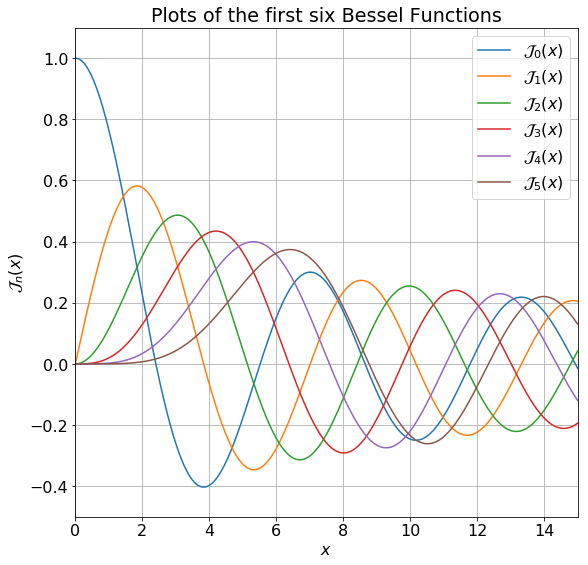

In [14]:
import scipy.special as sp

xlims = (0, 15)
x = np.linspace(xlims[0], xlims[1], 1000)

plt.figure(figsize=(9, 9))
for v in range(0, 6):
    plt.plot(x, sp.jv(v, x))

plt.xlim(xlims)
plt.ylim((-0.5, 1.1))
plt.legend(('$\mathcal{J}_0(x)$', '$\mathcal{J}_1(x)$', '$\mathcal{J}_2(x)$',
           '$\mathcal{J}_3(x)$', '$\mathcal{J}_4(x)$', '$\mathcal{J}_5(x)$'),
           loc = 0)
plt.xlabel('$x$')
plt.ylabel('$\mathcal{J}_n(x)$')
plt.title('Plots of the first six Bessel Functions')                                
plt.grid(True)

<a id='legendre'></a>

## Legendre Polynomials

These are "just" polynomials, so maybe conceptually simpler than Bessel functions. Their special feature is that the coefficients are chosen so that they are mutually orthogonal over the range $[-1,1]$. They are given by the formula

$$ P_n(x) = \frac{1}{2^n n!} \frac{d^n}{dx^n} (x^2 -1)^n $$

They tend to crop up in the sort of problems which naturally use spherical coordinates and/or spherical harmonics, such as fluctuations in the CMB, "sunquakes" in our local star or (at the other end of the scale range) electron orbitals in the hydrogen atom.

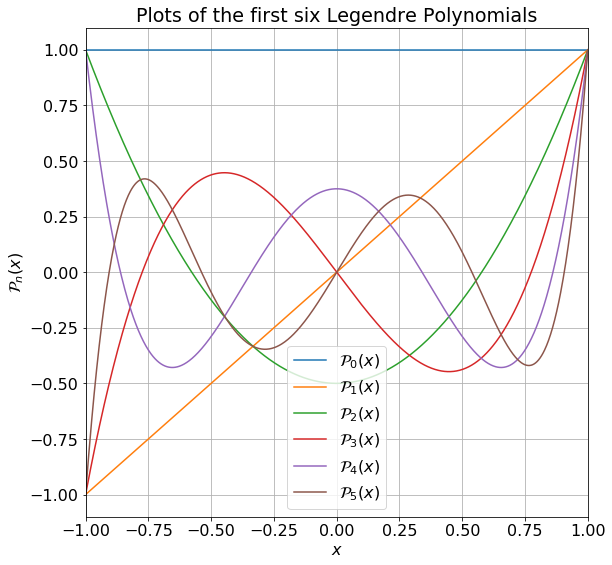

In [15]:
# from numpy.polynomial.legendre import Legendre

xlims = (-1, 1)
x = np.linspace(xlims[0], xlims[1], 1000)

plt.figure(figsize=(9, 9))
for v in range(0, 6):
    plt.plot(x, sp.legendre(v)(x))

plt.xlim(xlims)
plt.ylim((-1.1, 1.1))
plt.legend(('$\mathcal{P}_0(x)$', '$\mathcal{P}_1(x)$', '$\mathcal{P}_2(x)$',
           '$\mathcal{P}_3(x)$', '$\mathcal{P}_4(x)$', '$\mathcal{P}_5(x)$'),
           loc = 0)
plt.xlabel('$x$')
plt.ylabel('$\mathcal{P}_n(x)$')
plt.title('Plots of the first six Legendre Polynomials')                                
plt.grid(True)

<a id='refs'></a>

## References

Boas, "Mathematical methods in the physical sciences"